In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from cryptography.hazmat.primitives.ciphers import (
    Cipher, algorithms, modes
)
from cryptography.hazmat.primitives.asymmetric import rsa , padding , utils
from cryptography.hazmat.primitives import serialization , hashes
from cryptography.hazmat.backends import default_backend

In [2]:
def show_pic(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    ax.imshow(img)
#     plt.title(name)

In [3]:
def load_img(imgPath):
    img = cv2.imread(imgPath)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [4]:
def load_show_img(imgPath):
    img = load_img(imgPath)
    show_pic(img)
    return img

In [36]:
def read_file(fileName):
    file = open(fileName, "r")
    message = file.read()
    file.close()
    return message

In [37]:
def write_file(fileName, message):
    file = open(fileName, "w")
    file.write(message)
    file.close()

In [7]:
# Utility functions to convert data to binary

In [8]:
def pixel2binary(pixel):
    
  if type(pixel) == bytes or type(pixel) == np.ndarray:
    result= [ format(i, "08b") for i in pixel ]
    
  else:
    raise TypeError("Input type is not supported")
    
  return result  

In [9]:
def cipher2binary(message):
    
  if type(message) == bytes:
    result= ''.join([ format(i, "08b") for i in message ])

  else:
    raise TypeError("Input type is not supported")
    
  return result  

# Cover image for steganography

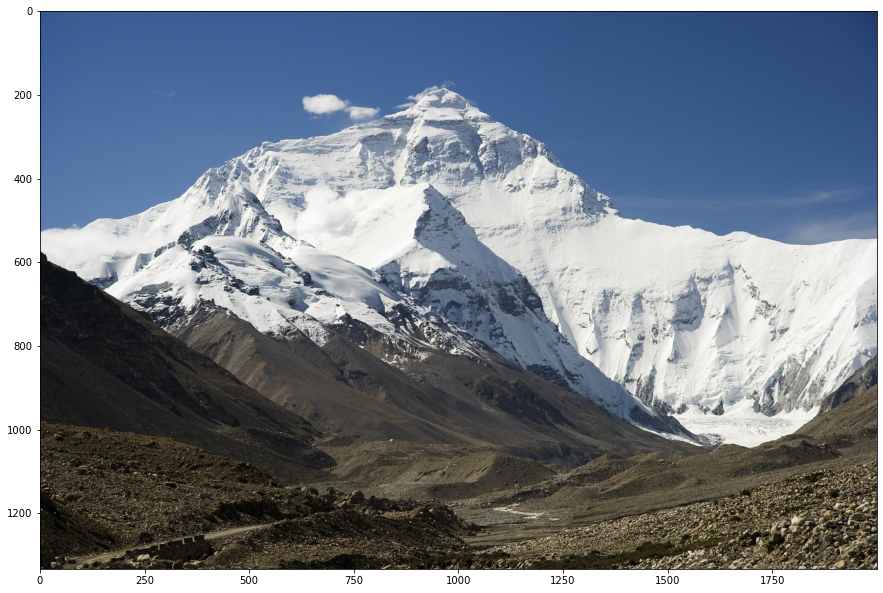

In [10]:
imgFileName = 'content/mountain.jpg'
img = load_show_img(imgFileName)

# Steganography encoder & decoder functions

In [11]:
def encode_data_to_img(imgFileName, data):
    
    list1=[ ]
    
    if (len(data) == 0): 
      raise ValueError('Data is empty')
  
#     filename = input("Enter the name of the New Image after Encoding(without extension):")
#     filename += '.png'
    
    img = load_img(imgFileName)
    no_bytes=(img.shape[0] * img.shape[1] * 3) // 8
    
    print("Maximum bytes to encode:", no_bytes-3)
    
    
#     # Using the below as delimeter
    delim = b'***'
    data+=delim
    
    if(len(data)>no_bytes):
        raise ValueError("Error encountered Insufficient bytes, Need Bigger Image or give Less Data !!")
        
    data_binary= cipher2binary(data)
    print(data_binary)
    
    #number of bits
    data_len=len(data_binary)
    
    print("The Length of Binary data",data_len)
    
    data_index = 0
    
    for row in img:
        for pixel in row:
          r, g, b = pixel2binary(pixel)

          if data_index < data_len:
              # hiding the data into LSB(Least Significant Bit) of Red Pixel
              pixel[0] = int(r[:-1] + data_binary[data_index], 2) #changing to binary after overwrriting the LSB bit of Red Pixel
              data_index += 1
              list1.append(pixel[0])

          if data_index < data_len:
             # hiding the data into LSB of Green Pixel
              pixel[1] = int(g[:-1] + data_binary[data_index], 2) #changing to binary after overwrriting the LSB bit of Green Pixel
              data_index += 1
              list1.append(pixel[1])

          if data_index < data_len:
              # hiding the data into LSB of  Blue Pixel
              pixel[2] = int(b[:-1] + data_binary[data_index], 2) #changing to binary after overwrriting the LSB bit of Blue pixel
              data_index += 1
              list1.append(pixel[2])

              # if data is encoded, just breaking out of the Loop
          if data_index >= data_len:
              break
    
    encryptedImgName = 'encryption/encrypted.png'
    cv2.imwrite(encryptedImgName,img)
    
    print("Encoded the data successfully and the image is successfully saved as ",encryptedImgName)
    return encryptedImgName

In [12]:
def decode_data_from_img(imgFileName):

  img = load_img(imgFileName)
  finished = False
  counter = 0
  binary_data = ''
  decoded_data = b''
  pixels_count = (img.shape[0] * img.shape[1] * 3)
  
  for row in img:
      for pixel in row:
        
          r, g, b = pixel2binary(pixel) 
          binary_data += r[-1]  #Extracting Encoded data from the LSB bit of Red Pixel as we have stored in LSB bit of every pixel.
          binary_data += g[-1]  #Extracting Encoded data from the LSB bit of Green Pixel
          binary_data += b[-1]  #Extracting Encoded data from LSB bit of Blue Pixel
          counter += 3
          
          # last 3 bytes
          if(counter%24 == 0) or counter == pixels_count:
              # splitting last 3 bytes by 8-bits
              last3bytes = [ binary_data[i: i+8] for i in range(0, len(binary_data), 8) ]
#               print(last3bytes)
              for byte in last3bytes:
                 # convert string of bits to one byte
                  b = int(byte, 2).to_bytes((len(byte) + 7) // 8, 'big')
                  decoded_data += b
                  if decoded_data[-3:] == b"***": #Checking if we have reached the delimeter which is "*****"
                      finished = True
                      break
                    
              binary_data = ""
              last3bytes = []
          if finished:
              break
      if finished:
        break
                
  print("The Encoded data was :--",decoded_data[:-3])
  return decoded_data[:-3]

# AES encryption and decryption functions

In [13]:
def encrypt_AES(key, iv, plaintext):
    # Construct an AES-GCM Cipher object with the given key and a
    # randomly generated IV.
    encryptor = Cipher(
        algorithms.AES(key),
        modes.GCM(iv),
    ).encryptor()


    # Encrypt the plaintext and get the associated ciphertext.
    # GCM does not require padding.
    ciphertext = encryptor.update(plaintext)

    return ciphertext

def decrypt_AES(key, iv, ciphertext):
    # Construct a Cipher object, with the key, iv, and additionally the
    # GCM tag used for authenticating the message.
    decryptor = Cipher(
        algorithms.AES(key),
        modes.GCM(iv),
    ).decryptor()


    # Decryption gets us the authenticated plaintext.
    # If the tag does not match an InvalidTag exception will be raised.
    return decryptor.update(ciphertext)

# AES with steganography Driver Function

In [47]:
def AES_encrypt_and_encode(imgFileName, textFileName, key, iv):
    message = read_file(textFileName)
    ciphertext = encrypt_AES(key,iv , message.encode('utf-8'))
    
    encryptedImgPath = encode_data_to_img(imgFileName, ciphertext)
    
    print("Original Message: ", message)
    print("Ciphertext: ", ciphertext)
    
    load_show_img(encryptedImgPath)
    
    return encryptedImgPath
    

def AES_decode_and_decrypt(imgPath, restoredFileName, key, iv):
    
    ciphertext = decode_data_from_img(imgPath)
    message = decrypt_AES(key, iv, ciphertext)
    originalMessage = message.decode('utf-8')
    
    print("Ciphertext: ", ciphertext)
    print("Original Message: ", originalMessage)
    
    write_file(restoredFileName, originalMessage)
    
    return originalMessage
    

# RSA private and public key functions

In [31]:
# Create private key
def Create_private_key():
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=2048,
        backend=default_backend()
    )
    return private_key

# Create public key
def Create_public_key(private_key):
    public_key = private_key.public_key()
    return public_key

def print_readable_private_key(private_key):
    # Print human readable key
    pem = private_key.private_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PrivateFormat.TraditionalOpenSSL,
        encryption_algorithm=serialization.NoEncryption()
    )
    pem_data = pem.splitlines()
    print(pem_data)

# RSA encrypt and decrypt functions

In [32]:
#RSA
#encrypt take a plaintext as a bytes like AES -->(utf-8)
#return a ciphertext as bytes -->(utf-8)
def encrypt_RSA(public_key, plaintext):
    ciphertext = public_key.encrypt(
        plaintext,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA1()),
            algorithm=hashes.SHA1(),
            label=None
        )
    )

    return ciphertext

#decrypt take a ciphertext as a bytes like AES -->(utf-8)
#return a plaintext as bytes -->(utf-8)
def decrypt_RSA(private_key, ciphertext):
    plaintext = private_key.decrypt(
        ciphertext,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA1()),
            algorithm=hashes.SHA1(),
            label=None
        )
    )

    return plaintext

# RSA with steganography Driver Function

In [33]:
def RSA_encrypt_and_encode(imgFileName, textFileName, public_key):
    message = read_file(textFileName)
    ciphertext = encrypt_RSA(public_key, message.encode("utf-8"))
    
    encryptedImgPath = encode_data_to_img(imgFileName, ciphertext)
    
    print("Original Message: ", message)
    print("Ciphertext: ", ciphertext)
    
    load_show_img(encryptedImgPath)
    
    return encryptedImgPath
    

def RSA_decode_and_decrypt(imgPath, restoredFileName , private_key):
    
    ciphertext = decode_data_from_img(imgPath)
    message = decrypt_RSA(private_key, ciphertext)
    originalMessage = message.decode('utf-8')
    
    print("Ciphertext: ", ciphertext)
    print("Original Message: ", originalMessage)
    
    write_file(restoredFileName, originalMessage)
    
    return originalMessage
    

# Testing AES with image steganography

Maximum bytes to encode: 83629
000111000111011011110011000111000001001110111011001010100010101000101010
The Length of Binary data 72
Encoded the data successfully and the image is successfully saved as  encryption/encrypted.png
Original Message:  hello

Ciphertext:  b'\x1cv\xf3\x1c\x13\xbb'


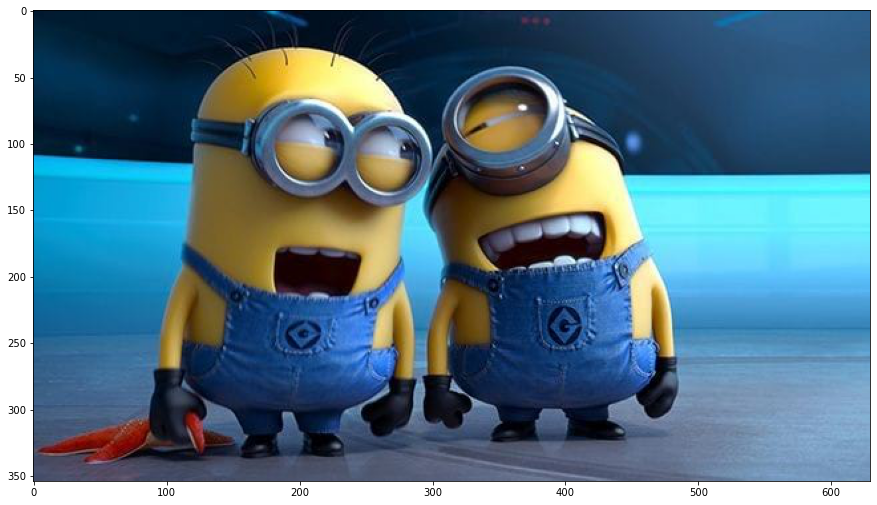

In [52]:
# Generate a random 256-bit key.
#key = os.urandom(32)
# Generate a random 96-bit IV.
key="mayarhanafy12345"
key = key.encode("utf-8")
iv="mayarhanafy11111"
iv= iv.encode("utf-8")

textFileName = "content/message.txt"
restoredFileName = "F:/study/projects/crypto_project/file_encryption_with_image_steganography/content/restored_AES.txt"
imageFileName = 'content/minion.jpg'

encryptedImgPath = AES_encrypt_and_encode(imageFileName, textFileName, key, iv)
#origianMessage = AES_decode_and_decrypt(encryptedImgPath, restoredFileName, key, iv)

# Testing AES with image steganography

Maximum bytes to encode: 83629
010101000110001011001100011010001001011000000000000101110010011100111111000010111111110101001110010010100110100110000001011010011111110100100100101001011100111011110110011000111110111000110011111001100001010011100010100011100001100101101010011001101000000100100010001001011000000001000100000000110001010001011001001010010001000001100010110000111110101011101100011101000000010111001011010111011001011001111100111110011001011111101101010111110001101000101111110000110011010001110001100110000011010101100100100100010101101111100001010101010000101111001001011001111001011111101010011001011010101001110111000000111101010000000010110011100101001110111000010110000101001010101111110011101001111011100011000000001001101100010111110000101111011010100101011111010101100011101110010111011111111000000111101111011101010111011111100010001000001000111011111100001010001100001111011100011101011100011100111101101011010100011111101001111011100011100001000110000111110110000111111000011

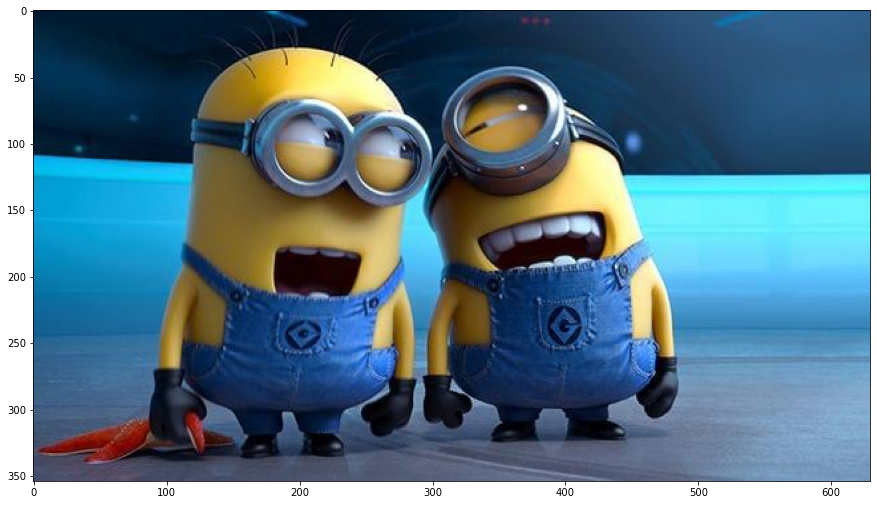

In [35]:
private_key = Create_private_key()
public_key = Create_public_key(private_key)

textFileName = "content/message.txt"
restoredFileName = "content/restored_RSA.txt"
imageFileName = 'content/minion.jpg'

encryptedImgPath = RSA_encrypt_and_encode(imageFileName, textFileName, public_key)

origianMessage = RSA_decode_and_decrypt(encryptedImgPath, restoredFileName, private_key)

In [53]:
from tkinter import *
from tkinter.filedialog import askopenfilename
#from tkinter import ttk
from tkinter import scrolledtext


def en_de():
    global win1
    win1 =Tk()
    win1.geometry('600x400')
    L1 =Label (win1, text='AES  or  RSA',font=(60))
    L1.pack(pady=100)   
    B1 = Button (win1, text='Encrypt', width=15, height=2, font=10, bg="PowderBlue").place(x=100,y=215)
    B2 = Button (win1, text='Decrypt', width=15, height=2, font=10, bg="PowderBlue",command=AES_decrypt_input).place(x=350,y=215)
    win1.mainloop()

    
    

def upload_file():
    filename = askopenfilename()
    ent1=Text(win2,font=10,width=30,height=2)
    ent1.place(x=200,y=180)
    ent1.insert(INSERT, filename)
    global  filePath
    filePath=ent1.get("1.0","end")


def Get_key():
    global decrypted_key
    decrypted_key = txt3.get("1.0","end")  
    
def Get_ImagePath():
    filename = askopenfilename()
    txt1=Text(win2,font=10,width=30,height=2)
    txt1.place(x=230,y=130)
    txt1.insert(INSERT, filename)
    global encrypted_ImagePath
    encrypted_ImagePath = txt1.get("1.0","end")  
    
    
def AES_decrypt_input():
    win1.destroy()
    global win2  
    win2 =Tk()
    win2.geometry('600x400')
    L2 =Label (win2, text='AES Decrypt Input',font=(60))
    L2.pack(pady=50)
    L3 =Label (win2, text='Encrypted image path',font=(60)).place(x=40,y=130)
    L4 =Label (win2, text='Restored file path',font=(60)).place(x=40,y=180)
    L5 =Label (win2, text='Key',font=(60)).place(x=40,y=230)
    
    global txt1
    txt1 = Text(win2,width=30,height=2)
    txt1.place(x=230,y=130)
    
   
    encrypted_Image_Path = txt1.get("1.0","end")
    txt2 = Text(win2,width=30,height=2).place(x=230,y=180)
    
    global txt3
    txt3 = Text(win2,width=30,height=2)
    txt3.place(x=230,y=230)
    
    key_button = Button(win2, text="...", width=2,height=2 ,font=('Century 20 bold',5),bg=('lightgray'),fg=('black'),command=Get_key)
    key_button.place(x=210, y= 240)
    
    key_button = Button(win2, text="...", width=2,height=2 ,font=('Century 20 bold',5),bg=('lightgray'),fg=('black'),command=Get_ImagePath)
    key_button.place(x=210, y= 130)
    select_filepath = Button (win2, text='Select file path', width=15,height=2,font=10, bg="PowderBlue",command=upload_file)
    select_filepath.place(x=100,y=300)
    Next = Button (win2, text='Next', width=15,height=2,font=10, bg="PowderBlue",command=AES_decrypt_ouput).place(x=330,y=300)


    


def AES_decrypt_ouput():
    win2.destroy()
    global win3
    win3 =Tk()
    win3.geometry('600x400')
    L=Label (win3, text='AES Decrypt Output',font=(60))
    L.pack(pady=40)
    Message=Label(win3, text='Message',font=(60)).place(x=20,y=100)
    
    iv="mayarhanafy11111"
    iv= iv.encode("utf-8")
    key = decrypted_key.encode("utf-8")
    origianMessage = AES_decode_and_decrypt(encrypted_ImagePath[:-1], filePath[:-1], key[:-1], iv)
    print( origianMessage)
    #output = Text(win3,width=50,height=9).place(x=70,y=150)
    originalMessage = scrolledtext.ScrolledText(win3,wrap=WORD,width=60,height=9).place(x=70,y=140)                                                               
    home = Button (win3, text='Next', width=15,height=2,font=10, bg="PowderBlue",command=destroy).place(x=240,y=310)
    
    


    
def destroy():
     win3.destroy()
     en_de()

In [54]:
 en_de()

The Encoded data was :-- b'\x1cv\xf3\x1c\x13\xbb'
Ciphertext:  b'\x1cv\xf3\x1c\x13\xbb'
Original Message:  hello

hello

F:/study/projects/crypto_project/file_encryption_with_image_steganography/content/restored_AES.txt

mayarhanafy12345

F:/study/projects/crypto_project/file_encryption_with_image_steganography/encryption/encrypted.png



In [55]:
# iv taken from user (todo)